In [1]:
! pip install -q datasets tqdm

In [2]:
import collections
import random
import os
import time
import json
from PIL import Image
import io
import urllib
import uuid
from concurrent.futures import ThreadPoolExecutor
from functools import partial

import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from datasets.utils.file_utils import get_datasets_user_agent
import matplotlib.pyplot as plt
import tensorflow as tf
from datasets import load_dataset

In [3]:
from huggingface_hub import notebook_login
notebook_login()

In [72]:
# Add the relevant ISO code for the language you want to work with.
# iso639_3_letter_code = "hau"
# iso639_3_letter_code = "tha"
iso639_3_letter_code = "kir"

# Download the language specific dataset from HF.
dataset = load_dataset("sil-ai/bloom-captioning", iso639_3_letter_code, 
                       use_auth_token=True, download_mode='force_redownload')

/opt/conda/lib/python3.7/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset bloom_captioning downloaded and prepared to /root/.cache/huggingface/datasets/sil-ai___bloom_captioning/kir/0.0.0/8efe15718b4a50170c9add75b453aec13ec1c5216111d21815428536fe5913ca. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [73]:
! rm -rf images
! mkdir images

USER_AGENT = get_datasets_user_agent()

def fetch_single_image(image_url, timeout=None, retries=0):
    request = urllib.request.Request(
        image_url,
        data=None,
        headers={"user-agent": USER_AGENT},
    )
    with urllib.request.urlopen(request, timeout=timeout) as req:
        if 'png' in image_url:
          png = Image.open(io.BytesIO(req.read())).convert('RGBA')
          png.load() # required for png.split()
          background = Image.new("RGB", png.size, (255, 255, 255))
          background.paste(png, mask=png.split()[3]) # 3 is the alpha channel
          image_id = str(uuid.uuid4())
          image_path = "images/" + image_id + ".jpg"
          background.save(image_path, 'JPEG', quality=80)
        else:
          image = Image.open(io.BytesIO(req.read()))
          image_id = str(uuid.uuid4())
          image_path = "images/" + image_id + ".jpg"
          image.save(image_path)
    return image_path

def fetch_images(batch, num_threads, timeout=None, retries=3):
    fetch_single_image_with_args = partial(fetch_single_image, timeout=timeout, retries=retries)
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        batch["image_path"] = list(executor.map(fetch_single_image_with_args, batch["image_url"]))
    return batch

num_threads = 20
dataset = dataset.map(fetch_images, batched=True, batch_size=100, fn_kwargs={"num_threads": num_threads})

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/40 [00:00<?, ?ba/s]

In [74]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [75]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [76]:
# Get unique train images
encode_train = sorted(set(dataset['train']['image_path']))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

# Get unique test images
encode_test = sorted(set(dataset['test']['image_path']))

# Feel free to change batch_size according to your system configuration
image_dataset_test = tf.data.Dataset.from_tensor_slices(encode_test)
image_dataset_test = image_dataset_test.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset_test):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


In [77]:
# Add some special tokens and clean up new line characters.
train_captions = [f"<start> {x} <end>" for x in dataset['train']['caption']]
train_captions = [x.replace('\n', ' ') for x in train_captions]
test_captions = [f"<start> {x} <end>" for x in dataset['test']['caption']]
test_captions = [x.replace('\n', ' ') for x in test_captions]

In [78]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 30
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

caption_dataset_test = tf.data.Dataset.from_tensor_slices(test_captions)
cap_vector_test = caption_dataset_test.map(lambda x: tokenizer(x))

In [79]:
# Create some mas between images, vectors, and captions
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(dataset['train']['image_path'], cap_vector):
  img_to_cap_vector[img].append(cap)

img_name_train = []
cap_train = []
for imgt in list(img_to_cap_vector.keys()):
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_to_cap_vector_test = collections.defaultdict(list)
for img, cap in zip(dataset['test']['image_path'], cap_vector_test):
  img_to_cap_vector_test[img].append(cap)

img_name_test = []
cap_test = []
for imgv in list(img_to_cap_vector_test.keys()):
  capv_len = len(img_to_cap_vector_test[imgv])
  img_name_test.extend([imgv] * capv_len)
  cap_test.extend(img_to_cap_vector_test[imgv])

In [80]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 2048
units = 1024
num_steps = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [81]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [82]:
dataset_tf = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset_tf = dataset_tf.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset_tf = dataset_tf.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_tf = dataset_tf.prefetch(buffer_size=tf.data.AUTOTUNE)

In [83]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights


In [84]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


In [85]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


In [86]:
# Initialize the encoder and decoder
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [87]:
# Training config.
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# Loss function to use during training.
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [88]:
# Make sure we save checkpoints during training
checkpoint_path = "./checkpoints/kir/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [89]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [90]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [91]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index(tf.constant('<start>'))] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [92]:
# Adjust this depending on how long you want to train
EPOCHS = 30

# Train our model!
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset_tf):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 5.6513
Epoch 1 Loss 4.487598
Time taken for 1 epoch 78.81 sec

Epoch 2 Batch 0 Loss 4.3906
Epoch 2 Loss 4.257340
Time taken for 1 epoch 26.21 sec

Epoch 3 Batch 0 Loss 4.0300
Epoch 3 Loss 4.110504
Time taken for 1 epoch 26.18 sec

Epoch 4 Batch 0 Loss 3.9917
Epoch 4 Loss 3.904479
Time taken for 1 epoch 26.16 sec

Epoch 5 Batch 0 Loss 3.6570
Epoch 5 Loss 3.728815
Time taken for 1 epoch 26.35 sec

Epoch 6 Batch 0 Loss 3.7394
Epoch 6 Loss 3.519859
Time taken for 1 epoch 27.25 sec

Epoch 7 Batch 0 Loss 3.0430
Epoch 7 Loss 3.281556
Time taken for 1 epoch 26.29 sec

Epoch 8 Batch 0 Loss 2.9970
Epoch 8 Loss 3.022430
Time taken for 1 epoch 26.36 sec

Epoch 9 Batch 0 Loss 2.7866
Epoch 9 Loss 2.762455
Time taken for 1 epoch 26.20 sec

Epoch 10 Batch 0 Loss 2.5011
Epoch 10 Loss 2.486614
Time taken for 1 epoch 26.24 sec

Epoch 11 Batch 0 Loss 2.0804
Epoch 11 Loss 2.204319
Time taken for 1 epoch 27.12 sec

Epoch 12 Batch 0 Loss 1.8224
Epoch 12 Loss 1.917028
Time taken for 1 epo

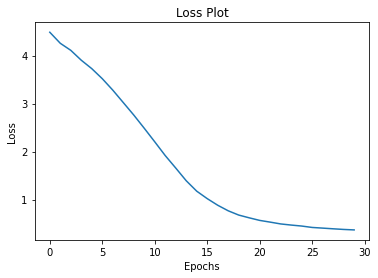

In [94]:
# Visualize our loss
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [95]:
def predict(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index(tf.constant('<start>'))], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(tf.constant(predicted_id)).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [96]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

## Inference

In [33]:
# import pandas as pd

# test_data = pd.read_csv('../input/purdue-test-dataset/test.csv')
# test_data.head()

In [97]:
del id_list

In [98]:
id_list = test_data.loc[test_data['ISO639-3'] == 'kir']['Id'].to_list()

In [99]:
# test_data['Predicted'] = ''

In [100]:
test_data.head()

,Id,ImageURL,ISO639-3,Predicted
0,0293a8c7-b69e-4c58-8caf-4a58e17bbacb_kir,https://bloom-vist.s3.amazonaws.com/%D0%A6%D0%...,kir,
1,02d89130-e6e5-4aea-88ed-99e100aafe84_tha,https://bloom-vist.s3.amazonaws.com/%E0%B9%82%...,tha,[UNK] [UNK] เมื่อชะนีกินอิ่มชะนีก็จะไปเล่นกัน ...
2,04763763-d79a-4a97-a529-20c5178d7d2d_tha,https://bloom-vist.s3.amazonaws.com/%E0%B9%80%...,tha,[UNK]
3,0478f1ca-3db4-4025-a838-255d45b2c603_hau,https://bloom-vist.s3.amazonaws.com/Gallina%20...,hau,shanshani tana gwaninta kuma tana gwaninta kum...
4,04a00291-ef0f-4bb5-8b37-75d300ceffaf_kir,https://bloom-vist.s3.amazonaws.com/%D0%9C%D0%...,kir,


In [101]:
for id in id_list:
    image_url = test_data.loc[test_data['Id'] == id]['ImageURL'].to_list()[0]
    idx = test_data.loc[test_data['Id'] == id].index[0]
    image_path = fetch_single_image(image_url)
    image = image_path
    result, attention_plot = predict(image)
    predicted_caption = ' '.join(result).replace(' <end>', '')
    test_data.iloc[idx]['Predicted'] = predicted_caption

In [102]:
test_data.sample(10)

,Id,ImageURL,ISO639-3,Predicted
9,0cbcf57f-5726-4184-bb15-13ac7f067ae3_tha,https://bloom-vist.s3.amazonaws.com/%E0%B8%AB%...,tha,"[UNK] [UNK] [UNK] [UNK] "" [UNK] [UNK] [UNK] [U..."
64,5f4c3cb4-ea87-46e6-8be6-20e01ed50467_hau,https://bloom-vist.s3.amazonaws.com/01/image9.jpg,hau,ba ya ɗauki matarsa suka kai bitrus ya kuma ya...
75,7836836c-1ab2-4ab5-8b7a-be1fb8d41920_tha,https://bloom-vist.s3.amazonaws.com/%E0%B9%80%...,tha,[UNK] [UNK]
58,59602c7b-dc93-49cb-8383-d80b7e2fb77c_kir,https://bloom-vist.s3.amazonaws.com/%D0%A1%D1%...,kir,Алгач [UNK] [UNK] менен [UNK] менен [UNK] мене...
154,e16b1ae1-db48-4c27-97b1-294055d82fa3_tha,https://bloom-vist.s3.amazonaws.com/%E0%B8%AB%...,tha,[UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK...
43,3f2b9e45-8d41-408a-a36f-640285f63131_tha,https://bloom-vist.s3.amazonaws.com/%E0%B8%AB%...,tha,[UNK]
112,a9797210-2375-4b60-b8a5-61c64dde8a8f_hau,https://bloom-vist.s3.amazonaws.com/01/image2.jpg,hau,"allah ya kira shi da duhu, wanda ya kasance. a..."
145,d783941b-149d-4078-b02a-2c48de172f6c_hau,https://bloom-vist.s3.amazonaws.com/01/image8.jpg,hau,"sai faɗa maka wannan daren, gidiyon yana sabka..."
168,8d2e6ebf-97fd-45f3-9665-1cc3431c93ad_tha,https://bloom-vist.s3.amazonaws.com/test/testt...,tha,[UNK] [UNK] เเละทั้งสองก็ได้ตกลงที่จะช่วยเเม่น...
197,e0331a04-0515-45db-8295-b8d4055f14c2_kir,https://bloom-vist.s3.amazonaws.com/test/testk...,kir,[UNK] [UNK] [UNK] [UNK] [UNK] [UNK]


In [103]:
final_data = test_data.drop(['ImageURL','ISO639-3'],axis = 1)

In [104]:
final_data.head()

,Id,Predicted
0,0293a8c7-b69e-4c58-8caf-4a58e17bbacb_kir,‒ Кичинекей [UNK] [UNK]
1,02d89130-e6e5-4aea-88ed-99e100aafe84_tha,[UNK] [UNK] เมื่อชะนีกินอิ่มชะนีก็จะไปเล่นกัน ...
2,04763763-d79a-4a97-a529-20c5178d7d2d_tha,[UNK]
3,0478f1ca-3db4-4025-a838-255d45b2c603_hau,shanshani tana gwaninta kuma tana gwaninta kum...
4,04a00291-ef0f-4bb5-8b37-75d300ceffaf_kir,Бирок мен [UNK] [UNK] [UNK] жана [UNK] [UNK] [...


In [105]:
final_data['new_predicted'] = ""

In [106]:
import re
final_captions = []
for i in range(len(final_data)):
    row = final_data.iloc[i]
    caption = row['Predicted']
    caption = caption.replace('[UNK]',"")
    caption = re.sub(' +', ' ', caption)
    final_captions.append(caption)

In [107]:
final_data['new_predicted'] = final_captions

In [108]:
final_data.head()

,Id,Predicted,new_predicted
0,0293a8c7-b69e-4c58-8caf-4a58e17bbacb_kir,‒ Кичинекей [UNK] [UNK],‒ Кичинекей
1,02d89130-e6e5-4aea-88ed-99e100aafe84_tha,[UNK] [UNK] เมื่อชะนีกินอิ่มชะนีก็จะไปเล่นกัน ...,เมื่อชะนีกินอิ่มชะนีก็จะไปเล่นกัน 2ตัว เซตาได...
2,04763763-d79a-4a97-a529-20c5178d7d2d_tha,[UNK],
3,0478f1ca-3db4-4025-a838-255d45b2c603_hau,shanshani tana gwaninta kuma tana gwaninta kum...,shanshani tana gwaninta kuma tana gwaninta kum...
4,04a00291-ef0f-4bb5-8b37-75d300ceffaf_kir,Бирок мен [UNK] [UNK] [UNK] жана [UNK] [UNK] [...,Бирок мен жана жана башка буюмдар менен деп Ба...


In [109]:
final_data = final_data.drop(['Predicted'],axis = 1)
final_data = final_data.rename(columns={"new_predicted": "Predicted"})
final_data.head()

,Id,Predicted
0,0293a8c7-b69e-4c58-8caf-4a58e17bbacb_kir,‒ Кичинекей
1,02d89130-e6e5-4aea-88ed-99e100aafe84_tha,เมื่อชะนีกินอิ่มชะนีก็จะไปเล่นกัน 2ตัว เซตาได...
2,04763763-d79a-4a97-a529-20c5178d7d2d_tha,
3,0478f1ca-3db4-4025-a838-255d45b2c603_hau,shanshani tana gwaninta kuma tana gwaninta kum...
4,04a00291-ef0f-4bb5-8b37-75d300ceffaf_kir,Бирок мен жана жана башка буюмдар менен деп Ба...


In [110]:
final_data.sample(5)

,Id,Predicted
134,c690c9e7-4b6f-4d50-9692-1c9ec93a434e_kir,"– Апа, карачы! – – деди капа болгон"
161,f68526f4-1288-4200-bbe5-f41a62e872b7_kir,деген менен жараша ар кандай башталды. эле ки...
114,ac2d2c6b-0d5a-4c83-ba33-5992a721b942_tha,
72,6bd3c4dd-685a-4f76-86ad-b7d77c22122e_kir,– деди
88,84cc2b95-f5be-443e-a85f-bb1867d2d388_tha,รอมาแสนนาน ขอทานอ่อนล้า ของที่แจกมา ไม...


In [111]:
final_data.to_csv(r'submission_max_30_dict_5000_more_emb_vp.csv',index = False)

In [112]:
from IPython.display import FileLink
FileLink(r'submission_max_30_dict_5000_more_emb_vp.csv')

/kaggle/working/submission_max_30_dict_5000_more_emb_vp.csv

# Donot run from here

In [3]:
import pandas as pd

best_submission_data = pd.read_csv('../input/best-submission-vp/submission_2_17NOV1124PM_NOUNK.csv')
durga_kir_preds_data = pd.read_csv('../input/durgakirenglishpreds/Kir_Predicted_captions (1).csv')

In [4]:
best_submission_data.head()

,Id,Predicted
0,0293a8c7-b69e-4c58-8caf-4a58e17bbacb_kir,– адамдардын колунан абага керек.
1,02d89130-e6e5-4aea-88ed-99e100aafe84_tha,แจ๊ค
2,04763763-d79a-4a97-a529-20c5178d7d2d_tha,
3,0478f1ca-3db4-4025-a838-255d45b2c603_hau,"shanshani ta harba ƙwallo, kuma ta saka a raga..."
4,04a00291-ef0f-4bb5-8b37-75d300ceffaf_kir,Канча күн сайын эртең менен


In [5]:
durga_kir_preds_data = durga_kir_preds_data.drop(['Unnamed: 0'],axis = 1)

In [6]:
for i in range(len(durga_kir_preds_data)):
    row = durga_kir_preds_data.iloc[i]
    row_id = row["Id"]
    row_id = row_id + '_kir'
    durga_kir_preds_data.iloc[i]['Id'] = row_id

In [7]:
durga_kir_preds_data.head()

,Id,Predicted
0,0293a8c7-b69e-4c58-8caf-4a58e17bbacb_kir,Бул жана жана кандай
1,04a00291-ef0f-4bb5-8b37-75d300ceffaf_kir,Бул түсү кандай? Бул чарчы кандай Бул чарчы ...
2,0da41c23-0b28-46ba-853c-bbef07dfbbbc_kir,Бул түсү кандай? Бул чарчы кандай Бул чарчы ...
3,0de1bb36-93b8-4457-9570-33b72827c2f0_kir,Бул
4,0df6e791-2aab-4a7d-8c87-077cdc47c674_kir,Бул баарын атай аласызбы?


In [10]:
hau_df = pd.DataFrame()
kir_df = pd.DataFrame()

In [11]:
for i in range(len(best_submission_data)):
    row = best_submission_data.iloc[i]
    if 'hau' in row["Id"]:
        hau_df = hau_df.append(row)
    if 'kir' in row["Id"]:
        kir_df = tha_df.append(row)

In [294]:
final_df = pd.DataFrame()

In [295]:
final_df = pd.concat([hau_df,tha_df,durga_kir_preds_data])

In [297]:
final_df

,Id,Predicted
3,0478f1ca-3db4-4025-a838-255d45b2c603_hau,"shanshani ta harba ƙwallo, kuma ta saka a raga..."
13,0e8b77a0-5533-427a-a9cd-44197dff61a7_hau,sai ya sallami dabbobi. suka fara tare da saur...
16,10af9d71-faf2-43da-a96f-729e5cc10a12_hau,amma kurmin don ya sa ka sa wahala za ka ke za...
17,1278528d-1cfe-4516-ad37-f700823444dd_hau,"lokacin da kaza tana shigowa gida, sai ta gamu..."
20,161317c8-7265-4968-9d2d-01fd90990367_hau,bala ya ce akwai koma gida.
...,...,...
62,06d4f633-edcd-46b5-bd83-f6d349cb5445_kir,Бул түсү кандай? Бул чарчы кандай
63,d8f01179-768f-4272-8309-b1bbf34188be_kir,Бул көк
64,e0331a04-0515-45db-8295-b8d4055f14c2_kir,Бул баарын атай аласызбы?
65,20b040af-6cc2-4f62-b6ef-52f05e7559a8_kir,Бул түсү кандай? Бул чарчы кандай Бул чарчы ...


In [298]:
final_data.to_csv(r'submission_combined_durga_vatsal_preds.csv',index = False)

In [299]:
from IPython.display import FileLink
FileLink(r'submission_combined_durga_vatsal_preds.csv')

/kaggle/working/submission_combined_durga_vatsal_preds.csv

# Mixing 3 predictions

In [21]:
tha_df = pd.read_csv('../input/mix-preds-dataset/thai_predicted_yu.csv')

In [22]:
tha_df.head()

,Unnamed: 0,Id,Predicted
0,1,02d89130-e6e5-4aea-88ed-99e100aafe84_tha,ร า ร ั น ต ่ า พ ่ า ด แ ก ต ิ ด ร
1,2,04763763-d79a-4a97-a529-20c5178d7d2d_tha,ห ม า ห น อ ง ป ร ุ ด ท ุ ก ก ร า
2,3,095b71cc-ef78-4861-af3f-5353c1bfcc59_tha,แ ล ็ ก ด ้ ด า ส ิ ๊ ด ว ิ ด น ี ่
3,4,0961231d-c9a7-4589-b5da-cf37b6016ccc_tha,ห น ึ ่ ง น ำ ด ำ ร ะ ร ะ ห ม า ว ย
4,5,09bb3c0d-e00b-4c6d-978f-218874717a72_tha,ผ ู ้ แ จ ก แ จ ก แ จ ก แ จ ้ แ จ ก


In [29]:
best_submission_data.sample(10)

,Id,Predicted
55,553a1c60-cfb7-45a1-84e0-d400d45b6766_hau,"mutanen da rana, almajiran cewa nuhu ya faɗa w..."
53,543cc2b5-e718-47b6-8510-f8bd991e6478_tha,
172,c3cd744b-ad22-47e8-b5ac-60beaedf40e7_tha,แม่วัวสอนลูกว่า
101,97d5aee9-06b9-42ae-bffc-2837d9a2fc42_hau,mai haske.
132,c489e001-b61e-4c35-8fdc-3be025e7ac4e_hau,yesu ya cewa ruwaye masu baftisma. da allah ya...
178,69698865-cbc8-45c0-b6df-90e2b3337c8a_kir,көбү үнүмдү – бул күнү ары-бери жок – деди чы...
145,d783941b-149d-4078-b02a-2c48de172f6c_hau,sai suka fara ta ci. cikin dawan kaza ta wurin...
74,74192351-5bbf-4e7f-8a67-a91a083c61d5_tha,"""ดูนั่นสิวงแหวนนั้นเท่จังเลย"" สตาร์คพูดด้วยควา..."
49,49ba950e-e4da-4b2e-8128-72f20ad5c857_kir,– деп сурады жаңылыктарды радиодон абага абага...
166,d330e247-72f4-4767-9dde-7b820f1b38df_tha,เมื่อก่อนนี้


In [33]:
missing_tha_list = []
for i in range(len(best_submission_data)):
    row = best_submission_data.iloc[i]
    if 'tha' in row['Id'] and row['Predicted'] == " ":
        missing_tha_list.append(row['Id'])

In [34]:
missing_tha_list

['04763763-d79a-4a97-a529-20c5178d7d2d_tha',
 '23457dd3-3afa-4526-a9eb-f5589261bad3_tha',
 '2fd6ff51-a8a2-499e-85cc-f194a32ddf6d_tha',
 '4f731aa7-b1ab-4fcd-9e00-0f37ecf592b9_tha',
 '543cc2b5-e718-47b6-8510-f8bd991e6478_tha',
 '5c5c3435-5934-4cde-8bd4-bb6b4d65533b_tha',
 '5d9cf303-71f7-4366-8af3-7ac33e1e8a29_tha',
 '8a28a196-5045-406f-bc64-6559e0bf73e1_tha',
 'a2f70594-3909-4bf7-9163-2e1b05141888_tha',
 'b0781e1e-094a-421c-bb94-6e6bf59a85b9_tha',
 'cc2b7bbe-0cc2-409c-9481-3ddcba38c841_tha',
 'dc060a5b-f8db-4397-aa90-fb87c4855308_tha',
 '8d2e6ebf-97fd-45f3-9665-1cc3431c93ad_tha']

In [40]:
for id in missing_tha_list:
    tha_row = tha_df[tha_df['Id'] == id]
    tha_preds = tha_row['Predicted']
    best_submission_data[best_submission_data['Id'] == id]['Predicted'] = tha_preds

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
